A notebook for running python code interactively as I try to figure out crosscal module.

First, having a weird issue with writing integers to strings and having decimal places show up, so I want to code interactively in order to check what is happening

In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append('/home/adams/commissioning/crosscal')
import crosscal as cc

obsrecordfile = '/home/adams/commissioning/APERTIF_observation_record_1nov2018.csv'
basedir='/data/adams/apertif/crosscal'
cfgfile='/home/adams/commissioning/crosscal/ccal.cfg'

import os
import numpy as np
from astropy.io import ascii
import apercal
import casacore.tables as pt
import matplotlib.pyplot as plt

In [3]:
#start apercal logger, because I'll use routines from it and that may be helpful:
#set up logging
%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/adams/commissioning/crosscal/ccal.log')

root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/adams/commissioning/crosscal/ccal.log


Setup logger with lib.setup_logger()


Reminder: Make sure observation record is up-to-date!
In switching scan mode
Reminder: Make sure observation record is up-to-date!
In switching scan mode
Will normalize solutions
plotting amplitude solutions


<IPython.core.display.Javascript object>


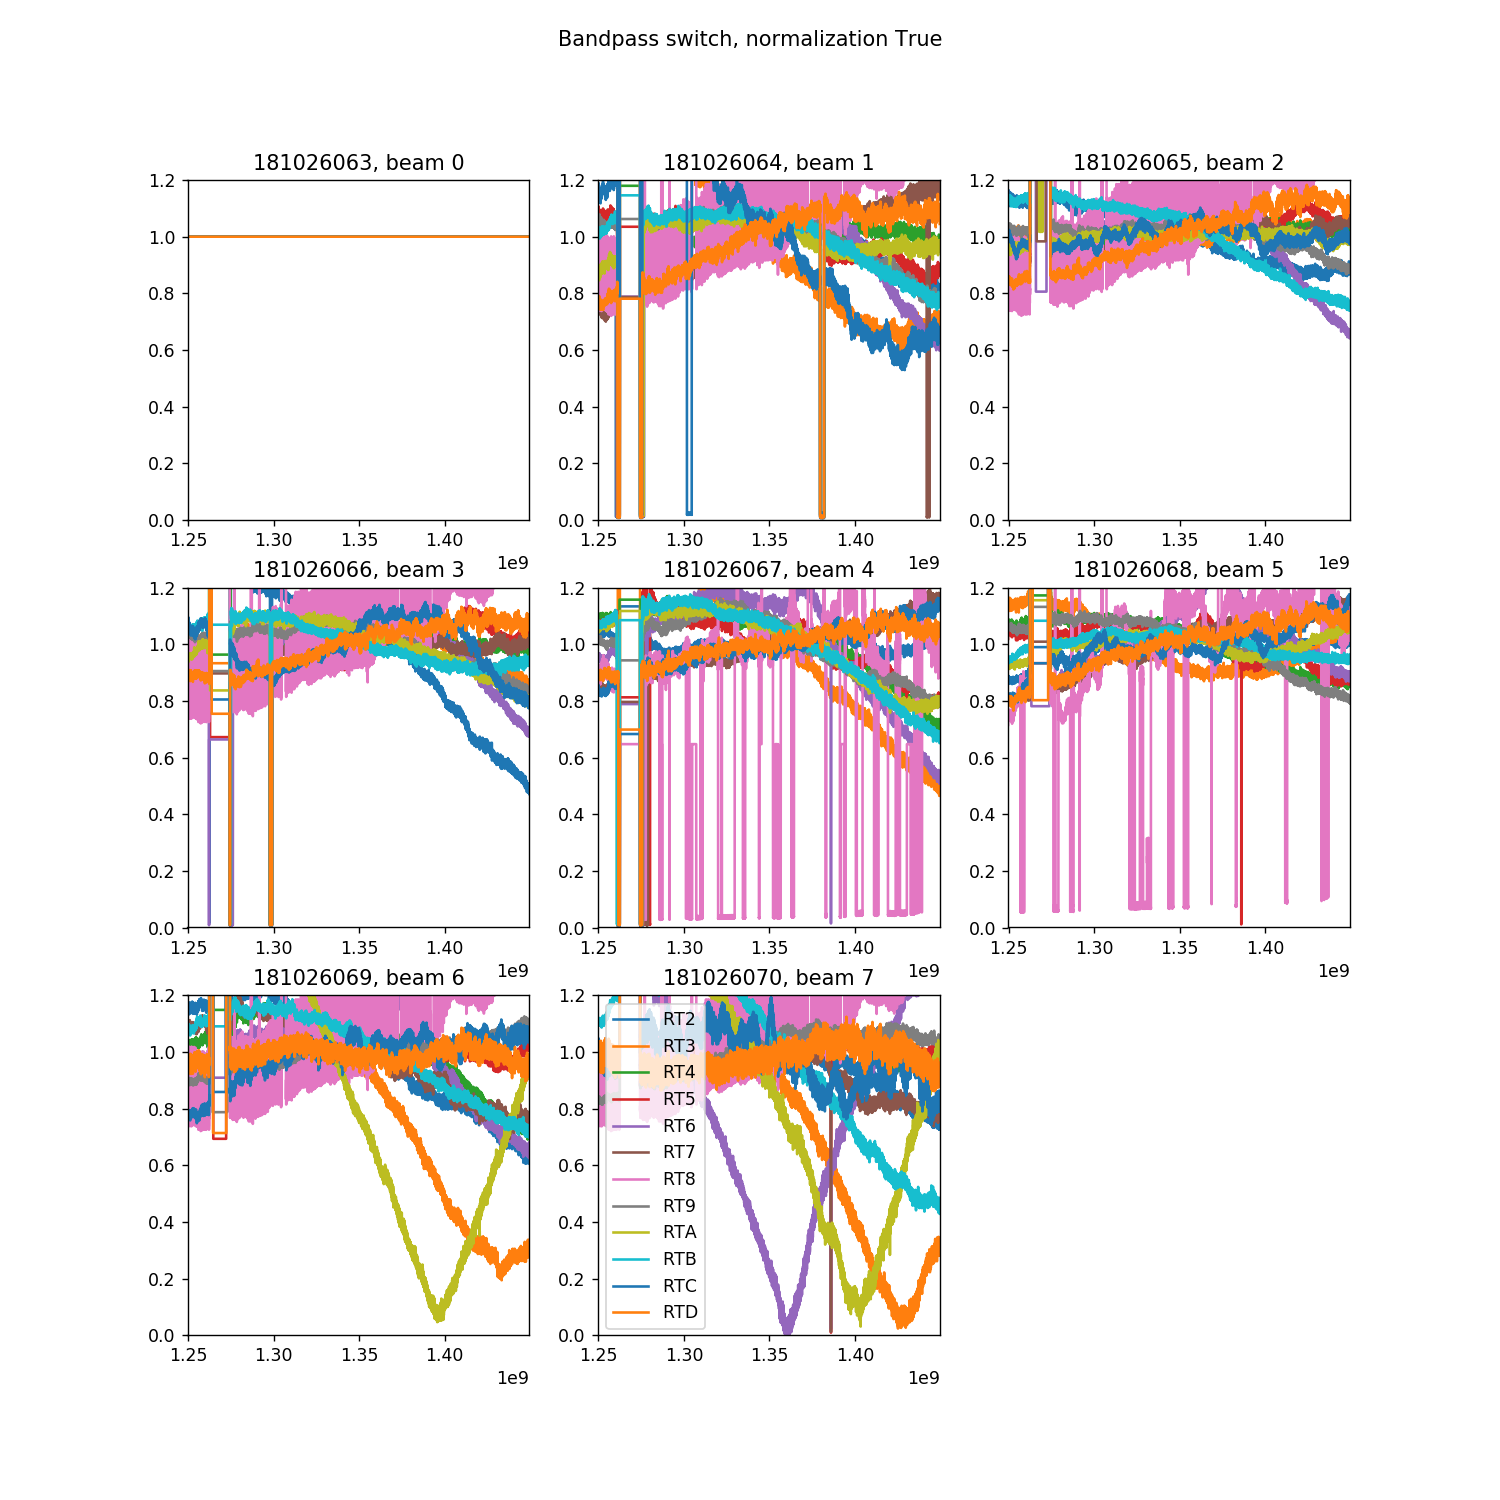

In [8]:
scans = cc.ScanSpecification()
scans.setstartscan('181026063')
scans.setendscan('181026070')
fig = cc.plot_compare_bp_beam(scans,obsrecordfile,basedir,
                              norm=True,refscan=181026063,plotmode='amp',pol=0,nx=3,plotsize=4,
                              ymin=0,ymax=1.2)

Reminder: Make sure observation record is up-to-date!
In switching scan mode
Reminder: Make sure observation record is up-to-date!
In switching scan mode
plotting amplitude solutions


<IPython.core.display.Javascript object>


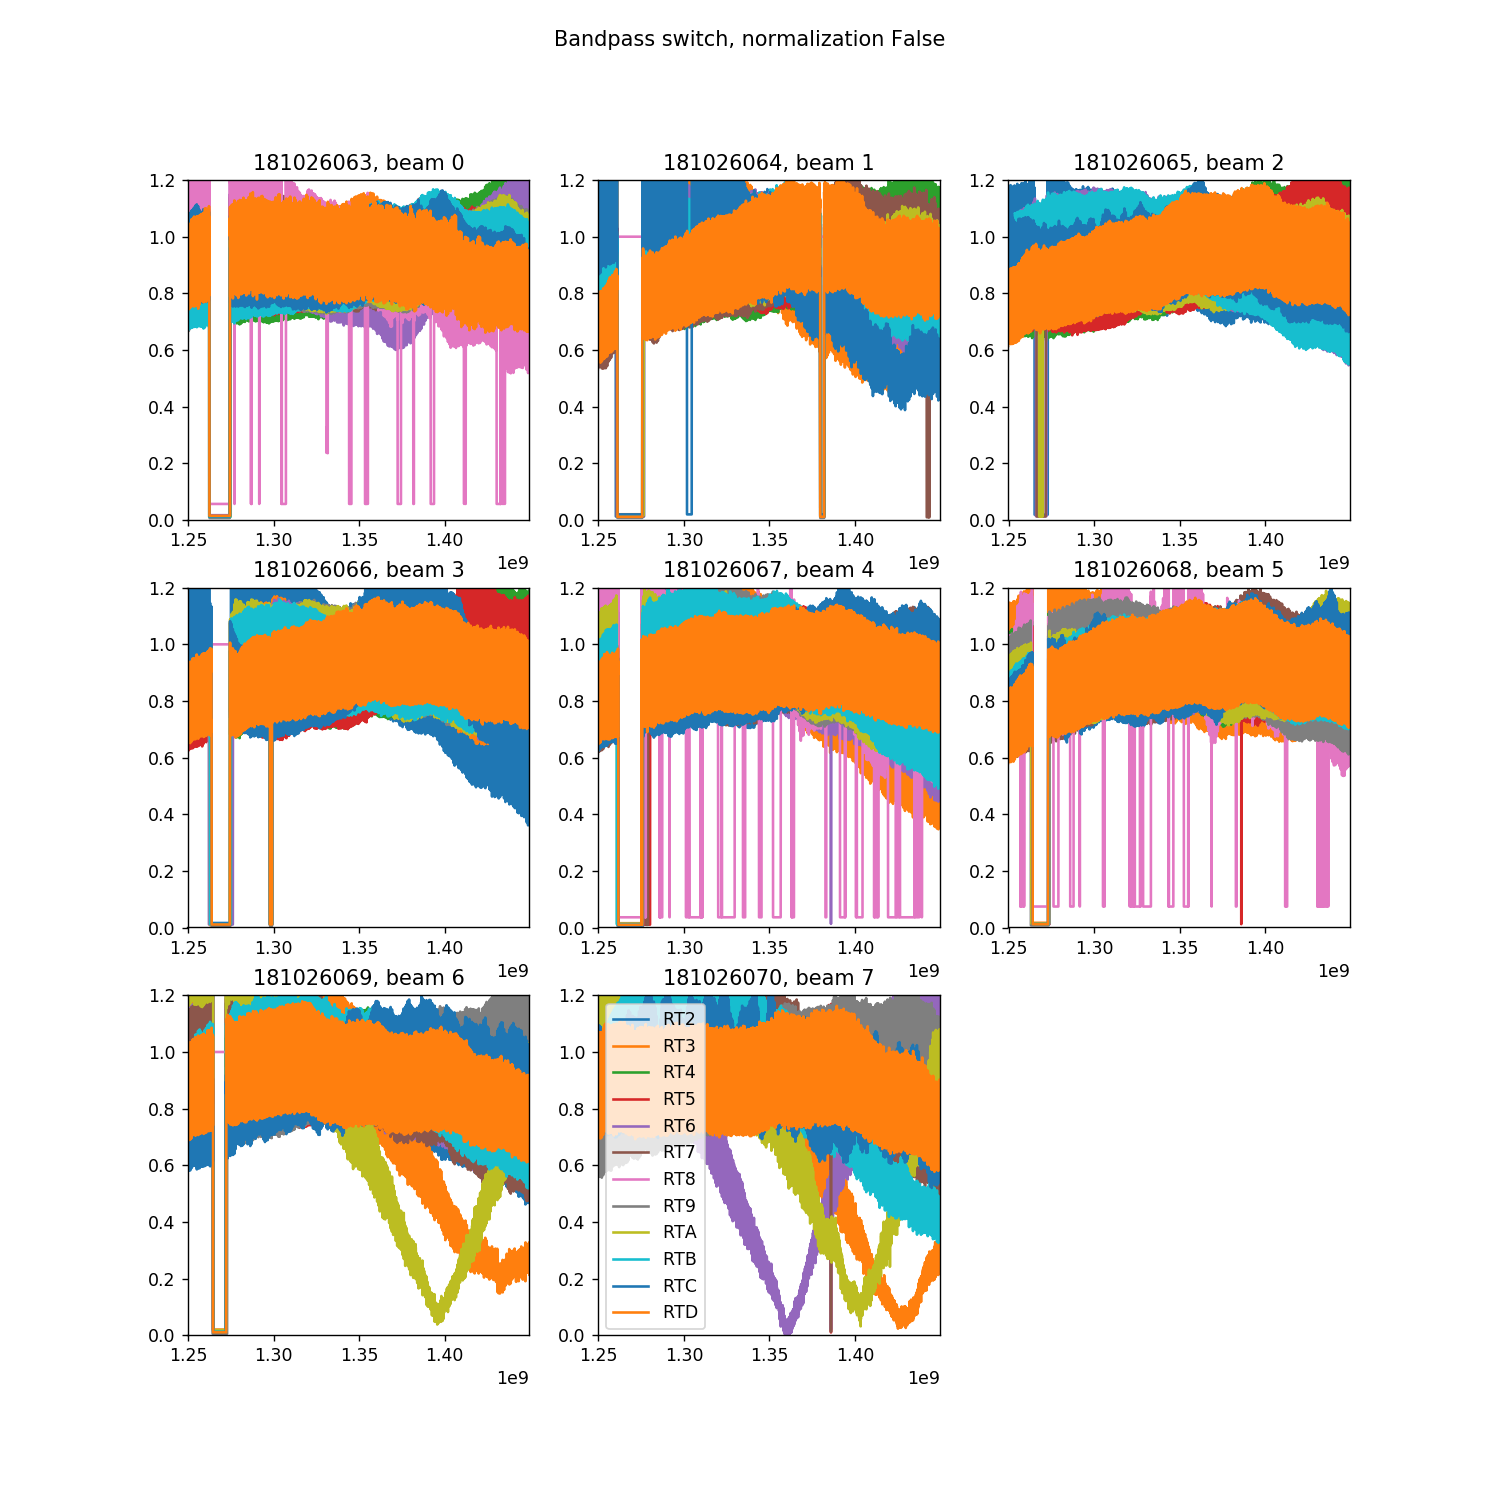

In [9]:
fig = cc.plot_compare_bp_beam(scans,obsrecordfile,basedir,
                              norm=False,refscan=181026063,plotmode='amp',pol=0,nx=3,plotsize=4,
                              ymin=0,ymax=1.2)

Reminder: Make sure observation record is up-to-date!
In switching scan mode
Reminder: Make sure observation record is up-to-date!
In switching scan mode
plotting phase solutions


<IPython.core.display.Javascript object>


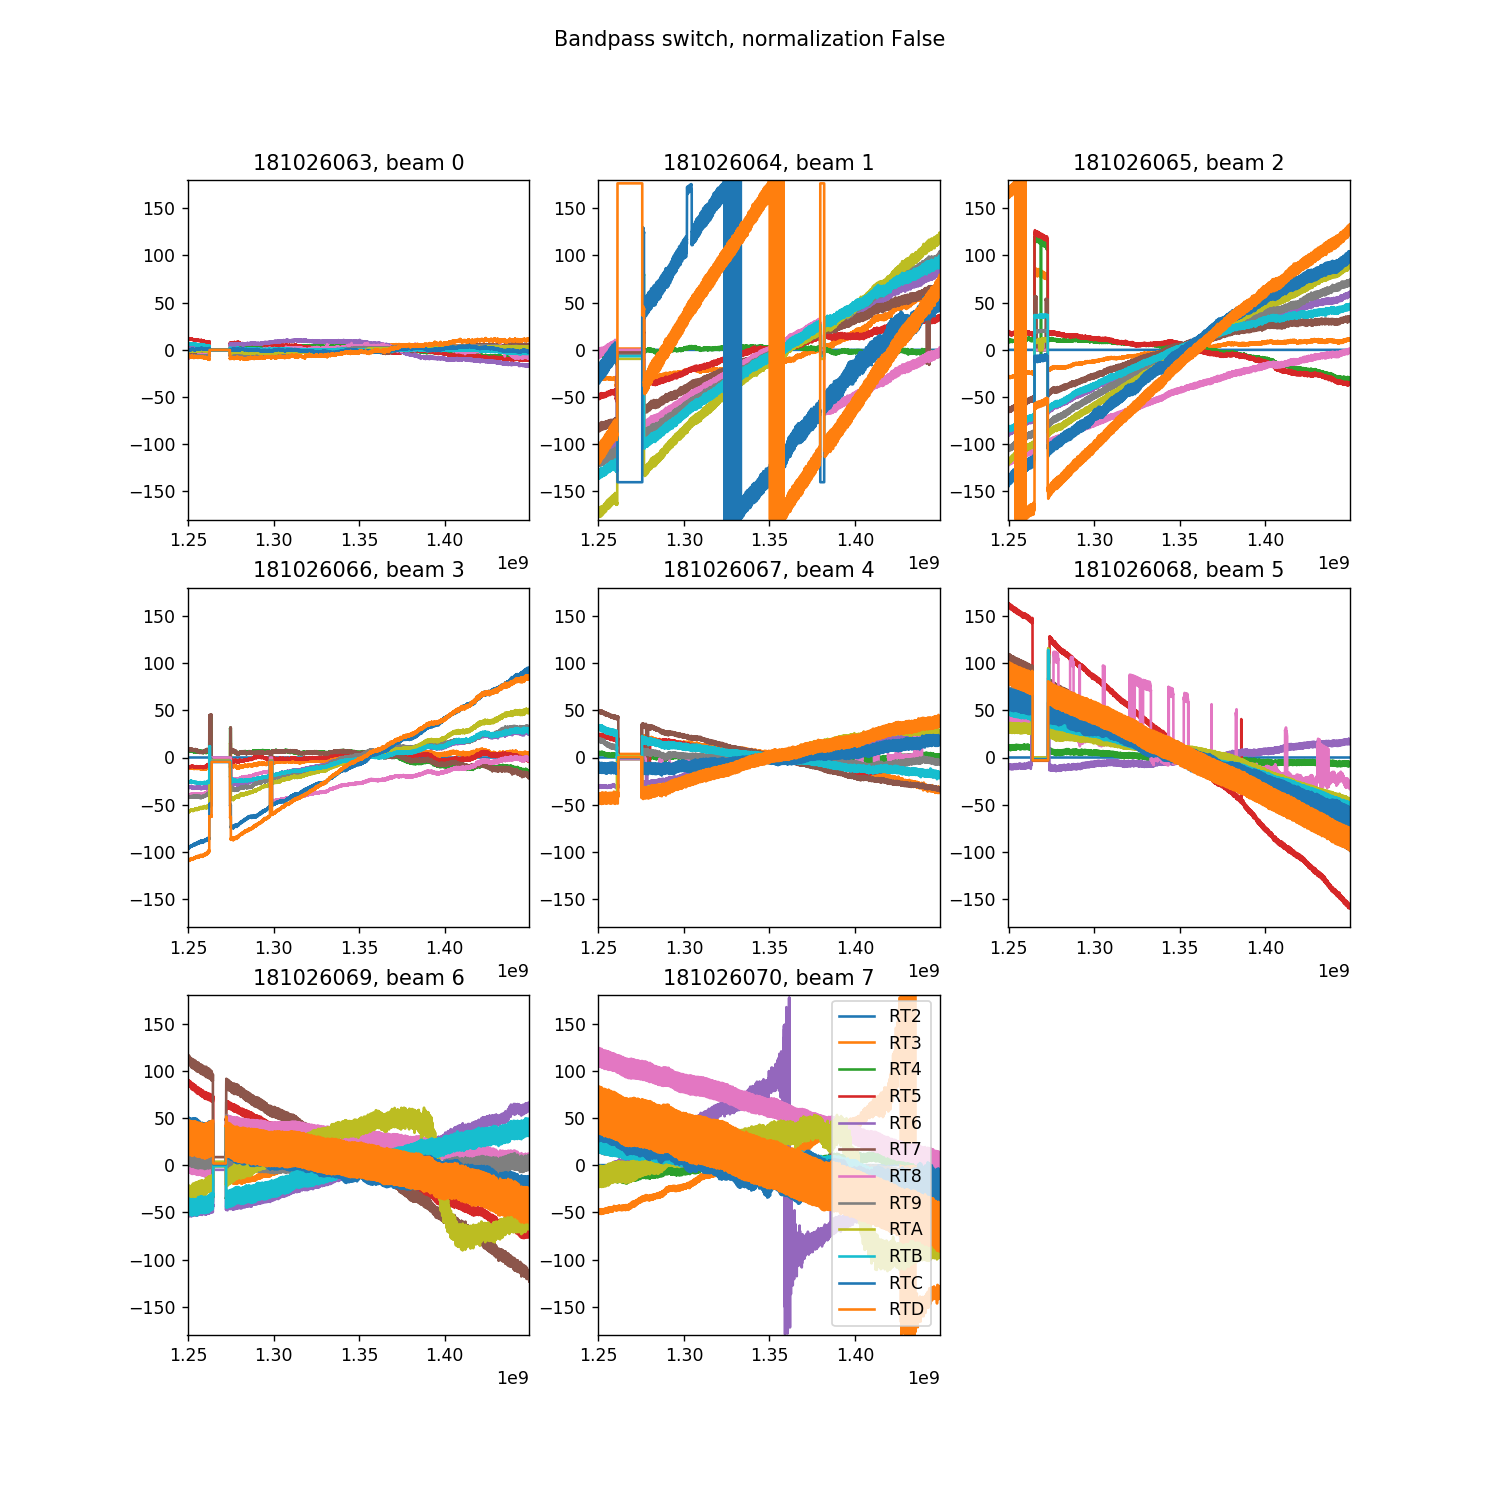

In [6]:
scans = cc.ScanSpecification()
scans.setstartscan('181026063')
scans.setendscan('181026070')
fig = cc.plot_compare_bp_beam(scans,obsrecordfile,basedir,norm=False,
                              plotmode='phase',pol=0,nx=3,plotsize=4,ymin=-180,ymax=180)



In [ ]:
#test flagging module
#Run on just a few scans!
scans = cc.ScanSpecification()
scans.setstartscan('181026063')
scans.setendscan('181026099')
scans.setbadscans(['181026085'])
cc.copy_scans(scans,obsrecordfile,basedir,run=True)
cc.fix_source_name(scans,obsrecordfile,basedir) #make sure source is recognized calibrator
cc.flag_scans(scans,obsrecordfile,basedir,cfgfile)
cc.calibrate_scans(scans,obsrecordfile,basedir,cfgfile)
fig = cc.plot_compare_bp_beam(scans,obsrecordfile,basedir,181026063,plotmode='amp',pol=0,nx=3,plotsize=4)

In [ ]:
fig = cc.plot_compare_bp_beam(scans,obsrecordfile,basedir,181026063,
                              plotmode='amp',pol=0,nx=3,plotsize=4,ymin=0.5,ymax=1.5)

In [ ]:
scans = cc.ScanSpecification()
scans.setstartscan('181026063')
scans.setendscan('181026064')
mode,scan_list,beam_list=cc.get_scan_list(scans,obsrecordfile)
ant_names,times,freqs,norm_bp_amp, norm_bp_phase = cc.compare_scan_solution_bp(scans,obsrecordfile,basedir,181026063)

In [ ]:
#now practice plotting:
plotsize=3
nplots = int(scans.nscan) #plots for each beam - color antennas, or make separate figures
fig = plt.figure(figsize=(6,3))
plt.suptitle('Bandpass', fontsize='large')

for n,(scan,beam) in enumerate(zip(scan_list,beam_list)):
    plt.subplot(1,2,n+1)
    #show each antenna:
    for a,ant in enumerate(ant_names):
        plt.plot(freqs[0,:],norm_bp_amp[a,:,0,n],label=ant) #choose pol 0 - will want to be able to select a pol and show all ants, or select ant and all pols,I think
    
    plt.title(scan)
    
plt.legend()

In [ ]:
print norm_bp_amp.shape

In [ ]:
#test flagging module
#Run on just a few scans!
scans = cc.ScanSpecification()
scans.setstartscan('181026063')
scans.setendscan('181026064')
cc.copy_scans(scans,obsrecordfile,basedir,run=True)
cc.fix_source_name(scans,obsrecordfile,basedir) #make sure source is recognized calibrator
cc.flag_scans(scans,obsrecordfile,basedir,cfgfile)
cc.calibrate_scans(scans,obsrecordfile,basedir,cfgfile)

In [ ]:
#The next step is to look at calibration tables. 
#I'll use taql for this, so good to play interactively first and figure out what I'm doing:
bptable = '/data/adams/apertif/crosscal/181026063/00/raw/WSRTA181026063_B000.Bscan'

#select time and calibration solutions - think that's cparam, from looking in CASA browsetable
#Might be different for polarized things - then fparam?
taql_time = "SELECT TIME FROM {0}".format(bptable)
t=pt.taql(taql_time)
times = t.getcol('TIME')

taql_antnames = "SELECT NAME FROM {0}::ANTENNA".format(bptable)
t= pt.taql(taql_antnames)
ant_names=t.getcol("NAME")
print ant_names

taql_freq = "SELECT CHAN_FREQ FROM {0}::SPECTRAL_WINDOW".format(bptable)
t = pt.taql(taql_freq)
freqs = t.getcol('CHAN_FREQ')
print freqs.shape

taql_amp = "SELECT abs(CPARAM) AS amp, arg(CPARAM) AS phase, TIME FROM {0}".format(bptable)
#taql_phase = "SELECT arg(CPARAM) AS phase FROM {0}".format(bptable)

t= pt.taql(taql_amp)
amp_sols=t.getcol('amp')
print amp_sols.shape
#print amp_sols.shape
t = pt.taql(taql_phase)
phase_sols = t.getcol('phase')
times = t.getcol('TIME')

print phase_sols.shape

#print amp_sols, phase_sols

In [ ]:
#So I think I have data values, but now want to try plotting
#also still not sure how I can properly get shape/info, but maybe I can leave that for later....

#print times[4]

#plot two different pols for ant 0
#plt.scatter(freqs[0,:],amp_sols[0,:,0],c='r')
#plt.scatter(freqs[0,:],amp_sols[0,:,1],c='g')


#plot single pol for each antenna:
for n in range(12):
    plt.scatter(freqs[0,:],amp_sols[n,:,0],label=ant_names[n])
    
plt.legend()


In [ ]:
#now also try testing for looking at complex gain solution: phase & amp (instead of bandpass)
phasetable = '/data/adams/apertif/crosscal/181026063/00/raw/WSRTA181026063_B000.G0ph'
amptable = '/data/adams/apertif/crosscal/181026063/00/raw/WSRTA181026063_B000.G1ap'

ant_names,times,freqs,amp_sols,phase_sols = cc.get_cal_sols(phasetable)


In [ ]:
print phase_sols.shape
print times.shape

#Okay - this doesn't work.
#Because there isn't a row per antenna anymore, but a value for each baseline
#So I'll have to think more about this
#but will continue in crosscal module focusing on bandpass, and come back to this

In [ ]:
scans = cc.ScanSpecification()
scans.setstartscan('181026063')
scans.setendscan('181026064')
mode,scan_list,beam_list = cc.get_scan_list(scans,obsrecordfile)

print scan_list
refscan = 181026065

ind = np.where(str(refscan) == scan_list)

print ind[0]

In [ ]:
scans = cc.ScanSpecification()
scans.setstartscan('181026063')
scans.setendscan('181026064')

In [ ]:
nscans = int(scans.endscan) - int(scans.startscan) + 1
print nscans, type(nscans)

scans.setnscan(nscans)
print scans.nscan,type(scans.nscan)

In [ ]:
scan_list = np.empty(int(scans.nscan),dtype=object)

for n in xrange(int(scans.nscan)):
    #print type(n)
    scannumber = int(scans.startscan)+n
    #print type(scannumber)
    scanstr = str(scannumber)
    print scanstr
    scan_list[n] = str(scannumber)
    
print scan_list

Okay - the solution was to set array type to object. Which, from the little I read, isn't best practice, but gets the job done.

Now I want to test my ability to properly/write format string command for getting data.

In [ ]:
mode,scan_list,beam_list = cc.get_scan_list(scans,obsrecordfile)

In [ ]:
 for scan,beam in zip(scan_list,beam_list):
        #first parse scan as required:
        #print scan, type(scan)
        scandate = scan[0:6]
        scannum = scan[6:9]
        #format string command to match usage:
            # ALTA data transfer: Uses the iROD client to transfer data from ALTA
            # Example usage: >> python getdata_alta.py 180316 004-010 00-36
            # V.A. Moss (vmoss.astro@gmail.com)
        #hope is that since I did sys.path.append('/home/adams/altadata'),
        #I don't have to specify full path
        string_command = "python /home/adams/altadata/getdata_alta.py {0} {1}-{1} {2:0>2}-{2:0>2}".format(scandate,scannum,beam)
        print string_command

In [ ]:
#test the verification mode of copy_scans
cc.copy_scans(scans,obsrecordfile,'/data/adams/apertif/beampos',run=True)

In [ ]:
#So I can run successfully on first source but not second.
#Is this because it's a non-central beam, or because of something else happening in the loop?

#doa  test where I don't have central beam scan:
scans = cc.ScanSpecification()
scans.setstartscan('181026064')
scans.setendscan('181026065')
basedir='/data/adams/apertif/crosscal_v2'
cc.copy_scans(scans,obsrecordfile,basedir,run=True)
cc.fix_source_name(scans,obsrecordfile,basedir) #make sure source is recognized calibrator
cc.flag_scans(scans,obsrecordfile,basedir,cfgfile)

In [ ]:
#open a MSfield table and look at it to figure out what i need to change
targetdir = basedir+'/raw/00'
scan= '181026063'
beam='0'
msfile = "{0}/WSRTA{1}_B{2:0>3}.MS".format(targetdir,scan,beam)
t_field = pt.table(msfile+"::FIELD", readonly=False)
print t_field
print t_field[0]['NAME']
print t_field[0]['SOURCE_ID']

name = t_field[0]['NAME']
name_split = name.split('_')
print name_split, name_split[0]

t_field.putcell("NAME", 0, name_split[0])  #update the phase direction
t_field.flush()

tfield = pt.table(msfile+"::FIELD", readonly=True)
print tfield[0]['NAME']

In [ ]:
name='3C147'
name_split = name.split('_')
print name_split,name_split[0]